<a href="https://colab.research.google.com/github/intimanjunath/Neural-network-using-numpy-keras-pytorch-and-jax/blob/main/6_tensorflow_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

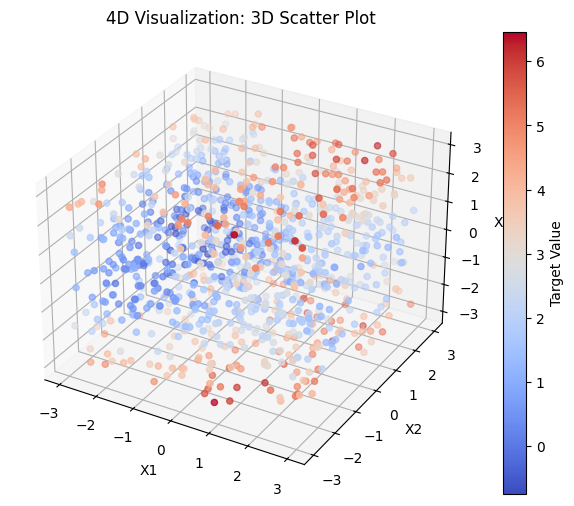

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

# Set random seed for reproducibility
np.random.seed(42)

def generate_data(n_samples=1000):
    # Generate three input features uniformly between -3 and 3
    x1 = np.random.uniform(-3, 3, n_samples)
    x2 = np.random.uniform(-3, 3, n_samples)
    x3 = np.random.uniform(-3, 3, n_samples)

    # Define a non-linear function:
    # y = sin(x1) + log(|x2|+1) + 0.5*(x3^2) + noise
    noise = np.random.normal(0, 0.1, n_samples)
    y = np.sin(x1) + np.log(np.abs(x2) + 1) + 0.5 * (x3 ** 2) + noise

    # Stack features into one array
    X = np.column_stack((x1, x2, x3))
    return X.astype(np.float32), y.astype(np.float32)

# Generate data
X, y = generate_data(1000)

# Visualize the data in a 3D scatter plot (4th dimension by color)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='coolwarm')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.colorbar(scatter, label='Target Value')
plt.title("4D Visualization: 3D Scatter Plot")
plt.show()

In [2]:
#Data Preprocessing: Train/Test Split and Conversion to Tensors

from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train)  # shape: (num_train, 3)
y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1))  # shape: (num_train, 1)
X_test_tf  = tf.convert_to_tensor(X_test)
y_test_tf  = tf.convert_to_tensor(y_test.reshape(-1, 1))

In [3]:
#Define the Neural Network Parameters (Weights and Biases)
# Set TensorFlow random seed for reproducibility
tf.random.set_seed(42)

# Network architecture parameters
input_dim = 3    # three input features
hidden_dim1 = 16 # first hidden layer neurons
hidden_dim2 = 8  # second hidden layer neurons
output_dim = 1   # regression output

# Initialize weights using a random normal distribution and small stddev
W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim1], stddev=0.1))
b1 = tf.Variable(tf.zeros([hidden_dim1]))

W2 = tf.Variable(tf.random.normal([hidden_dim1, hidden_dim2], stddev=0.1))
b2 = tf.Variable(tf.zeros([hidden_dim2]))

W3 = tf.Variable(tf.random.normal([hidden_dim2, output_dim], stddev=0.1))
b3 = tf.Variable(tf.zeros([output_dim]))

Define the Forward Pass Function

This function implements the forward propagation through the network. We use low‑level operations (tf.matmul, tf.nn.relu, and tf.nn.dropout) without using Keras layers.

In [4]:
def forward_pass(x, training=True):
    # Layer 1: linear transformation, ReLU activation, and dropout
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.nn.relu(z1)
    if training:
        a1 = tf.nn.dropout(a1, rate=0.2)

    # Layer 2: linear transformation, ReLU activation, and dropout
    z2 = tf.matmul(a1, W2) + b2
    a2 = tf.nn.relu(z2)
    if training:
        a2 = tf.nn.dropout(a2, rate=0.2)

    # Output Layer: linear transformation (no activation for regression)
    z3 = tf.matmul(a2, W3) + b3
    return z3

In [5]:
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [7]:
#Training Loop
optimizer = tf.optimizers.Adam(learning_rate=0.001)
epochs = 100
batch_size = 32

# Prepare a TensorFlow Dataset for mini-batch training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            predictions = forward_pass(batch_x, training=True)
            loss = compute_loss(batch_y, predictions)
        # Compute gradients with respect to all variables
        grads = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
        # Apply gradients to update variables
        optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2, W3, b3]))

        epoch_loss += loss.numpy()
        num_batches += 1
    if epoch % 50 == 0:
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

Epoch 0, Loss: 1.0499
Epoch 50, Loss: 0.7275


In [8]:
# Compute predictions on the test set without dropout
predictions_test = forward_pass(X_test_tf, training=False)
test_loss = compute_loss(y_test_tf, predictions_test)
print("Test Loss:", test_loss.numpy())

Test Loss: 0.3026184


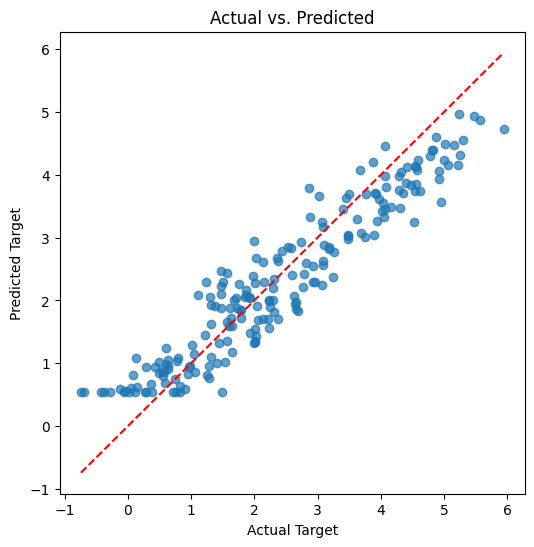

In [9]:
# Convert predictions and actual values to NumPy arrays
y_pred_np = predictions_test.numpy()
y_test_np = y_test_tf.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_test_np, y_pred_np, alpha=0.7)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel("Actual Target")
plt.ylabel("Predicted Target")
plt.title("Actual vs. Predicted")
plt.show()